[([[ 204., 2859., 1150.], [5658., 2856., 1150.], [2900.,  184., 1150.]], [('t0', 'a0', 0), ('t0', 'a1', 0), ('t0', 'a2', 0), ('a0', 't0', 0), ('a0', 'a1', 0), ('a0', 'a2', 0), ('a1', 't0', 0), ('a1', 'a0', 0), ('a1', 'a2', 0), ('a2', 't0', 0), ('a2', 'a0', 0), ('a2', 'a1', 0), ('t0', 'a0', 1), ('t0', 'a1', 1), ('t0', 'a2', 1)])]
Alice shape (32, 251)


FileNotFoundError: [Errno 2] No such file or directory: 'E:/ProjectCode/Sparsecode/Figures/Sparse-represenatation.pdf'

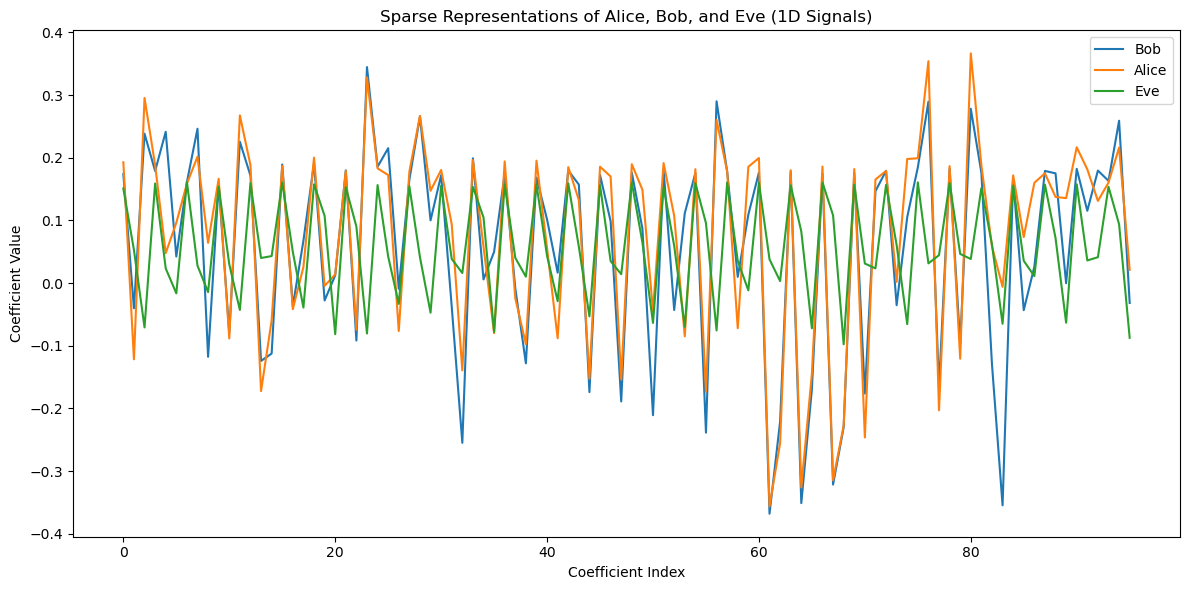

In [ ]:
import sys
import itertools
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.signal import correlate
from scipy.special import erfc
from sklearn.decomposition import DictionaryLearning
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
# from quantize import BER
#================== Ste Parameters =========================
Num_CIRs = 32 # Number of CIRs
gray_code_size = 3
quant_level = 4  # Level of Quantizer
N_components = 3  # Number of Sparse Components

# ================ Quantization & BER ========================
# Quantization function
def quantize_to_binary(cir, quant_level):
    min_value, max_value = np.min(cir), np.max(cir)
    bins = np.linspace(min_value, max_value, quant_level + 1)
    quantized_cir = np.digitize(cir, bins) - 1  # Subtract 1 to start from 0
    return quantized_cir
# =========== Load Data ===========================
# dir_path = os.path.dirname(os.path.realpath(__file__))
# file = dir_path + '\\files\\meas_symm_1.npz'
measurement = np.load('../../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
print(header)
number_CIRs = data['cirs'].shape[0]
num_CIRcomponents = data['cirs'].shape[2]
selected = [0, 3, 1, 4]  # Channels regarding 0 = Bob>Alice, 3 = Alice>Bob, 1 = Bob>Eve, 4 = Alice>Eve
data_points = np.zeros((len(selected), number_CIRs, num_CIRcomponents, 2), dtype=float) 

for idx, channel in enumerate(selected):
    data_points[idx, :, :, :] = data['cirs'][:number_CIRs, channel, :, :]

cir_data = np.sqrt(data_points[:, :, :, 0] ** 2 + data_points[:, :, :, 1] ** 2)  # (len(selected), number_CIRs, 251)


# =============== Extract the maximum value of each CIRs ================
cir_max = np.max(cir_data, axis=2)
# print(f'cir_max {cir_max.shape}')
Alice_max = cir_max[0, Num_CIRs*99:Num_CIRs*100]
Bob_max = cir_max[1, Num_CIRs*99:Num_CIRs*100]
Eve_max = cir_max[3, Num_CIRs*99:Num_CIRs*100]

# Calculate Pearson correlation coefficients
corr_alice_bob_max, _ = pearsonr(Alice_max, Bob_max)
corr_alice_eve_max, _ = pearsonr(Alice_max, Eve_max)
corr_bob_eve_max, _ = pearsonr(Bob_max, Eve_max)

# Quantize Alice, Bob, and Eve CIRs to binary values
quantized_Alice_max = quantize_to_binary(Alice_max, quant_level)
quantized_Bob_max = quantize_to_binary(Bob_max, quant_level)
quantized_Eve_max = quantize_to_binary(Eve_max, quant_level)

# Calculate the BER between Alice and Bob 
# ber_Alice_Bob_before_sparse_max = BER(quantized_Alice_max, quantized_Bob_max)
# ber_Alice_Eve_before_sparse_max = BER(quantized_Alice_max, quantized_Eve_max)

# =============== Select a number of CIRs  ================
Alice = cir_data[0, Num_CIRs*99:Num_CIRs*100]
Bob = cir_data[1, Num_CIRs*99:Num_CIRs*100]
Eve = cir_data[3, Num_CIRs*99:Num_CIRs*100]
print(f'Alice shape {Alice.shape}')
#  ==========  Evaluate the performance when we create a dictionary with some data and apply to another datset ===========
# Alice = cir_data[0, Num_CIRs:Num_CIRs*2+1]
# Bob = cir_data[1, Num_CIRs:Num_CIRs*2+1]
# Eve = cir_data[3, Num_CIRs:Num_CIRs*2+1]
# ================ Synchronize Alice and Bob's CIRs using cross-correlation

'''
cross_corr = correlate(Alice, Bob, mode='full')
delay = np.argmax(np.abs(cross_corr)) - len(Alice) + 1
synchronized_Alice = np.roll(Alice, -delay)  # Adjusted Alice CIR
Alice = synchronized_Alice

#The result shows that this line does not give us better performance,so synchronization is not needed in this method.

'''

# Flatten Alice, Bob, and Eve into 1D arrays
Alice_flat = Alice.flatten()
Bob_flat = Bob.flatten()
Eve_flat = Eve.flatten()

# Quantize Alice, Bob, and Eve CIRs to binary values
quantized_Alice_before_sparse = quantize_to_binary(Alice_flat, quant_level)
quantized_Bob_before_sparse = quantize_to_binary(Bob_flat, quant_level)
quantized_Eve_before_sparse = quantize_to_binary(Eve_flat, quant_level)

# Calculate the BER between Alice and Bob 
# ber_Alice_Bob_before_sparse = BER(quantized_Alice_before_sparse, quantized_Bob_before_sparse)
# ber_Alice_Eve_before_sparse = BER(quantized_Alice_before_sparse, quantized_Eve_before_sparse)

# Calculate Pearson correlation coefficients
corr_alice_bob_before, _ = pearsonr(Alice_flat, Bob_flat)
corr_alice_eve_before, _ = pearsonr(Alice_flat, Eve_flat)
corr_bob_eve_before, _ = pearsonr(Bob_flat, Eve_flat)

# ================ Sparse representation ========================
# Create Separate Dictionaries for Bob, Alice, and Eve
dl_bob = DictionaryLearning(n_components=N_components, transform_algorithm='lasso_lars')
dl_alice = DictionaryLearning(n_components=N_components, transform_algorithm='lasso_lars')
dl_eve = DictionaryLearning(n_components=N_components, transform_algorithm='lasso_lars')

# Fit the dictionaries separately for Bob, Alice, and Eve
dictionary_bob = dl_bob.fit_transform(Bob.T)  # Transpose to match (N_components, num_CIRcomponents)
dictionary_alice = dl_alice.fit_transform(Alice.T)
dictionary_eve = dl_eve.fit_transform(Eve.T)

# Create an OMP object
omp_alice = OrthogonalMatchingPursuit(n_nonzero_coefs=3)  # adjust the number of non-zero coefficients as needed
omp_bob = OrthogonalMatchingPursuit(n_nonzero_coefs=3)
omp_eve = OrthogonalMatchingPursuit(n_nonzero_coefs=3)

# Transform Alice, Bob, and Eve using OMP
sparse_rep_bob = np.zeros((Num_CIRs, N_components))
sparse_rep_alice = np.zeros((Num_CIRs, N_components))
sparse_rep_eve = np.zeros((Num_CIRs, N_components))

#Alice and Eve use the dictionary of Bob
for i in range(Num_CIRs):
    # For Bob
    omp_bob.fit(dictionary_bob, Bob[i]) 
    sparse_rep_bob[i] = omp_bob.coef_

    # For Alice
    omp_alice.fit(dictionary_bob, Alice[i]) 
    sparse_rep_alice[i] = omp_alice.coef_

    # For Eve
    omp_eve.fit(dictionary_bob, Eve[i]) 
    sparse_rep_eve[i] = omp_eve.coef_

# Alice and Eve use their own dictionary

# for i in range(Num_CIRs):
#     # For Bob
#     omp_bob.fit(dictionary_bob, Bob[i]) 
#     sparse_rep_bob[i] = omp_bob.coef_

#     # For Alice
#     omp_alice.fit(dictionary_alice, Alice[i]) 
#     sparse_rep_alice[i] = omp_alice.coef_

#     # For Eve
#     omp_eve.fit(dictionary_eve, Eve[i]) 
#     sparse_rep_eve[i] = omp_eve.coef_

# ============ Plot the result ================================

# Flatten the sparse representations for Alice, Bob, and Eve
sparse_rep_bob_1d = sparse_rep_bob.flatten()
sparse_rep_alice_1d = sparse_rep_alice.flatten()
sparse_rep_eve_1d = sparse_rep_eve.flatten()

# Create a plot with three 1D signals
plt.figure(figsize=(12, 6))

plt.plot(sparse_rep_bob_1d, label='Bob')
plt.plot(sparse_rep_alice_1d, label='Alice')
plt.plot(sparse_rep_eve_1d, label='Eve')

plt.title('Sparse Representations of Alice, Bob, and Eve (1D Signals)')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
# Save the plot for sparse CIRs
folder_path_sparse = 'E:/ProjectCode/Sparsecode/Figures/'
file_name_sparse = "Sparse-represenatation.pdf"
file_path_sparse = folder_path_sparse + file_name_sparse
plt.tight_layout()
plt.savefig(file_path_sparse)
plt.show()
# Quantize Alice, Bob, and Eve CIRs to binary values
quantized_Alice = quantize_to_binary(sparse_rep_alice_1d, quant_level)
quantized_Bob = quantize_to_binary(sparse_rep_bob_1d, quant_level)
quantized_Eve = quantize_to_binary(sparse_rep_eve_1d, quant_level)

# Calculate the Bit Error Rate (BER) between Alice and Bob after sparse
# ber_Alice_Bob_after_sparse = BER(quantized_Alice, quantized_Bob)

# # Calculate the Bit Error Rate (BER) between Alice and Eve after sparse
# ber_Alice_Eve_after_sparse = BER(quantized_Alice, quantized_Eve)
# Calculate Pearson correlation coefficients
corr_alice_bob, _ = pearsonr(sparse_rep_alice_1d, sparse_rep_bob_1d)
corr_alice_eve, _ = pearsonr(sparse_rep_alice_1d, sparse_rep_eve_1d)
corr_bob_eve, _ = pearsonr(sparse_rep_bob_1d, sparse_rep_eve_1d)

# # ================ PCA dimensionality reduction ========================
# Perform PCA separately for each CIR
# Initialize PCA for each CIR and fit to the data
pca_Alice = PCA(n_components = N_components)
pca_Bob = PCA(n_components = N_components)
pca_Eve = PCA(n_components = N_components)

PCA_Alice = pca_Alice.fit_transform(Alice)
PCA_Bob = pca_Alice.fit_transform(Bob)
PCA_Eve = pca_Alice.fit_transform(Eve)

# # if Bob use the pca component that Alice sent to him

# PCA_Alice = pca_Alice.fit_transform(Alice)
# PCA_Bob = pca_Alice.fit_transform(Bob)
# PCA_Eve = pca_Alice.fit_transform(Eve)

# Flatten the PCA representations for Alice, Bob, and Eve
pca_rep_bob_1d = PCA_Bob.flatten()
pca_rep_alice_1d = PCA_Alice.flatten()
pca_rep_eve_1d = PCA_Eve.flatten()

# Calculate Pearson correlation coefficients
corr_alice_bob_pca, _ = pearsonr(pca_rep_bob_1d, pca_rep_alice_1d)
corr_alice_eve_pca, _ = pearsonr(pca_rep_alice_1d,pca_rep_eve_1d)
corr_bob_eve_pca, _ = pearsonr(pca_rep_bob_1d, pca_rep_eve_1d)

# Quantize the PCA-transformed CIRs to binary values
quantized_pca_Alice = quantize_to_binary(pca_rep_alice_1d, quant_level)
quantized_pca_Bob = quantize_to_binary(pca_rep_bob_1d, quant_level)
quantized_pca_Eve = quantize_to_binary(pca_rep_eve_1d, quant_level)

# Calculate the BER between Alice and Bob after PCA
# ber_Alice_Bob_after_pca = BER(quantized_pca_Alice, quantized_pca_Bob)
# # Calculate the BER between Alice and Eve after PCA
# ber_Alice_Eve_after_pca = BER(quantized_pca_Alice, quantized_pca_Eve)
# =========== prints ====================================
print('======== Correlation Coefficients ========')
print()
print(f"Pearson correlation between Alice and Bob with Max: {corr_alice_bob_max}")
print(f"Pearson correlation between Alice and Eve with Max: {corr_alice_eve_max}")
print(f"Pearson correlation between Bob and Eve with Max: {corr_bob_eve_max}")
print()
print(f"Pearson correlation between Alice and Bob before sparse: {corr_alice_bob_before}")
print(f"Pearson correlation between Alice and Eve before sparse: {corr_alice_eve_before}")
print(f"Pearson correlation between Bob and Eve before sparse: {corr_bob_eve_before}")
print()
print(f'Pearson Correlation (Alice vs. Bob) after sparsity: {corr_alice_bob}')
print(f'Pearson Correlation (Alice vs. Eve) after sparsity: {corr_alice_eve}')
print(f'Pearson Correlation (Bob vs. Eve) after sparsity: {corr_bob_eve}')
print()
print(f'Pearson Correlation (Alice vs. Bob) after PCA: {corr_alice_bob_pca}')
print(f'Pearson Correlation (Alice vs. Eve) after PCA: {corr_alice_eve_pca}')
print(f'Pearson Correlation (Bob vs. Eve) after PCA: {corr_bob_eve_pca}')
print()
print('======== BERs ========')
print()
print(f"BER between Alice and Bob before sparse_max : {ber_Alice_Bob_before_sparse_max:.5f}")
print(f"BER between Alice and Eve before sparse_max : {ber_Alice_Eve_before_sparse_max:.5f}")
print()
print(f"BER between Alice and Bob before sparse : {ber_Alice_Bob_before_sparse:.5f}")
print(f"BER between Alice and Eve before sparse : {ber_Alice_Eve_before_sparse:.5f}")
print()
print(f"BER between Alice and Bob after sparse : {ber_Alice_Bob_after_sparse:.5f}")
print(f"BER between Alice and Eve after sparse : {ber_Alice_Eve_after_sparse:.5f}")
print()
print(f"BER between Alice and Bob after PCA: {ber_Alice_Bob_after_pca:.5f}")
print(f"BER between Alice and Eve after PCA: {ber_Alice_Eve_after_pca:.5f}")

In [1]:
import numpy as np
from sklearn.decomposition import PCA

# Sample data with shape (2, 251) - 2 samples, each having 251 features
data = np.random.rand(2, 251)

# Transpose the data to make features as rows and samples as columns
data_transposed = data.T  # Shape becomes (251, 2)

# Apply PCA to reduce the 251 features to a lower number of components
n_components = 4
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data_transposed)  # Resulting shape will be (251, 4)

# Transpose back to original structure
pca_result = pca_result.T  # Shape becomes (4, 251)

print("Original data shape:", data.shape)
print("Transformed data shape:", pca_result.shape)

ValueError: n_components=4 must be between 0 and min(n_samples, n_features)=2 with svd_solver='covariance_eigh'

In [1]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

measurement = np.load('../../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:1000]
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)

alice_channel = 3  # Channel 3 is ALICE (legitimate)
eve_channel = 6  # Channel 6 is EVE (illegitimate)

def prepare_complex_dictionary(cirs):
    """
    Prepare dictionary from CIR signals by combining real and imaginary parts.
    Input:
        cirs: Array of shape (n_samples, n_timepoints, 2) where last dimension contains [real, imag]
    Output:
        Dictionary matrix where each column is a normalized CIR signal
    """
    # Combine real and imaginary parts
    n_samples, n_timepoints, _ = cirs.shape
    dictionary = np.zeros((n_timepoints * 2, n_samples))
    
    for i in range(n_samples):
        # Stack real and imaginary parts
        signal = np.concatenate([cirs[i, :, 0], cirs[i, :, 1]])
        # Normalize the signal
        dictionary[:, i] = signal / np.linalg.norm(signal)
        
    return dictionary

def sparse_code_signal(signal, dictionary, n_nonzero_coefs=10):
    """
    Perform sparse coding of a signal using OMP
    """
    # Combine real and imaginary parts of the test signal
    test_signal = np.concatenate([signal[:, 0], signal[:, 1]])
    
    # Use OMP for sparse coding
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(dictionary.T, test_signal)
    
    return omp.coef_

def classify_cir(test_signal, dictionary, train_labels, n_nonzero_coefs=10):
    """
    Classify a CIR signal using sparse representation
    """
    # Get sparse coefficients
    coefficients = sparse_code_signal(test_signal, dictionary, n_nonzero_coefs)
    
    # Calculate residuals for each class
    residuals = []
    unique_classes = np.unique(train_labels)
    
    for class_label in unique_classes:
        # Get indices for this class
        class_indices = np.where(train_labels == class_label)[0]
        
        # Create class-specific coefficients
        class_coeffs = np.zeros_like(coefficients)
        class_coeffs[class_indices] = coefficients[class_indices]
        
        # Reconstruct signal using only this class's coefficients
        reconstructed = dictionary @ class_coeffs
        
        # Calculate residual
        test_signal_combined = np.concatenate([test_signal[:, 0], test_signal[:, 1]])
        residual = np.linalg.norm(test_signal_combined - reconstructed)
        residuals.append(residual)
    
    # Return class with minimum residual
    return unique_classes[np.argmin(residuals)]

# Example usage:
# Feature Extraction
alice_train_CIRs = trainCIR[:, alice_channel, :, :]  # (800, 251, 2)
eve_train_CIRs = trainCIR[:, eve_channel, :, :] # (800, 251, 2)

# Labels
alice_train_labels = np.zeros(alice_train_CIRs.shape[0])  # Label '0' for Alice.
eve_train_labels = np.ones(eve_train_CIRs.shape[0])       # Label '1' for Eve.

train_labels = np.hstack((alice_train_labels, eve_train_labels))

# Prepare dictionary from training data
train_dictionary = prepare_complex_dictionary(trainCIR[:, alice_channel, :, :])  # For Alice's channel

alice_test_CIRs = testCIR[:, alice_channel, :, :]
eve_test_CIRs = testCIR[:, eve_channel, :, :]

# Create labels for Alice and Eve for testing
alice_test_labels = np.zeros(alice_test_CIRs.shape[0])  # Label '0' for Alice.
eve_test_labels = np.ones(eve_test_CIRs.shape[0])       # Label '1' for Eve.
test_labels = np.hstack((alice_test_labels, eve_test_labels))

# Classification
predictions = []
for test_signal in testCIR[:, alice_channel, :, :]:
    pred = classify_cir(test_signal, train_dictionary, train_labels)
    predictions.append(pred)
    
    
predictions = np.array(predictions)

accuracy = np.mean(predictions == test_labels)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")


ValueError: Found input variables with inconsistent numbers of samples: [800, 502]